# Solución prueba técnica para la posición de Data Scientist SHIMOKU 

In [1]:
import pandas as pd
import numpy as np
import missingno
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%run pandas-missing-extension.ipynb

Se carga el dataset **leads**

In [3]:
string_dict = {key: 'str' for key in ['Id', 'First Name', 'Discarded/Nurturing Reason']}
cat_dict = {key: 'category' for key in ['Use Case', 'Source', 'Status', 'Acquisition Campaign', 'City']}
float_dict = {key: 'float64' for key in ['Converted']}
date_cols = ['Created Date']

dtype_dict = string_dict | cat_dict | float_dict

# Se cargan el dataset leads
leads_df = pd.read_csv('leads.csv', dtype=dtype_dict, parse_dates=date_cols)

Se carga el dataset **offers**

In [4]:
string_dict = {key: 'str' for key in ['Id', 'Discount code', 'Loss Reason']}
cat_dict = {key: 'category' for key in ['Use Case', 'Status', 'Pain']}
float_dict = {key: 'float64' for key in ['Price']}
date_cols = ['Created Date', 'Close Date']

dtype_dict = string_dict | cat_dict | float_dict

# Se cargan el dataset offers
offers_df = pd.read_csv('offers.csv', dtype=dtype_dict, parse_dates=date_cols)

### Primeras filas del dataset leads

In [5]:
leads_df.head()

,Id,First Name,Use Case,Source,Status,Discarded/Nurturing Reason,Acquisition Campaign,Created Date,Converted,City
0,23okrabh,NaN,Corporate Events,Inbound,Nurturing,Not Fit,NaN,2018-05-26,0.0,Chicago
1,NaN,Taylor1 Harris1,NaN,Inbound,Discarded,Not feeling,Event Management Guide,2018-10-17,0.0,Denver
2,hbzt0kp1,Alex6 Jackson3,NaN,Inbound,Nurturing,Competitor,NaN,2019-03-29,0.0,Denver
3,velluwdq,Bailey2 Taylor6,Corporate Events,Inbound,Discarded,Not Target,NaN,2018-05-26,0.0,NaN
4,NaN,Drew5 Wilson5,Corporate Events,Inbound,Nurturing,Competitor,NaN,2018-10-17,0.0,NaN


### Primeras filas del dataset offers

In [6]:
offers_df.head()

,Id,Use Case,Status,Created Date,Close Date,Price,Discount code,Pain,Loss Reason
0,doqyhjtv,Educational Seminars,Closed Won,2019-11-17,2019-11-17,300.0,SAVEMORE50,operations,NaN
1,NaN,Sports Events,Closed Lost,2019-11-24,2019-11-25,150.0,NaN,operations,price
2,NaN,Sports Events,Closed Lost,2019-11-24,2019-11-25,768.0,HALFYEAR20G,operations,no response
3,cturqi48,Corporate Events,Closed Won,2019-05-07,2019-05-07,240.0,DISCOUNT50POWER,financial control,NaN
4,NaN,Sports Events,Closed Lost,2019-11-17,2019-11-25,240.0,SAVEMONTH50G,financial control,no response


Vemos que en ambos datasets la columna Id contiene valores nulos. Sin embargo, nuestra variable objetivo se encuentra en el dataset offers, por lo que vamos a prescindir de los registros del dataset leads que no cuenten con un Id no nulo que nos permita conectarlos con algun registro en la tabla offers. También vemos que en ambos conjuntos tenemos la variable **Use Case** que nos indica el caso de uso que el cliente requiere del servicio, por lo que será suficiente mantener la columna **Use Case** del conjunto offers.

In [7]:
# Se eliminan la columna 'Use Case' del dataset leads
leads_df.drop(columns=['Use Case'], axis=1, inplace=True)
len(leads_df)

61639

Antes de realizar el merge entre offers y leads debemos vamos a retirar de leads los registros con **Id's** nulos ya que se encontrarían consistencias entre **Id's** nulos de ambas tablas.

In [8]:
leads_df.dropna(subset=['Id'], inplace=True)
# Encontrar los índices en offers_df que están en leads_df
len(offers_df[offers_df['Id'].isin(leads_df['Id'])])/len(offers_df)

0.6200652528548124

El 62% de los **id's** no nulos de **offers** se encuentran también en **leads**. Verifiquemos también si existen duplicados en las columnas **Id's** o **First Name** de la tabla **leads**.

In [9]:
# Revisamos si existen Id's o nombres duplicados en 'leads'
print("-- Duplicates in the Leads dataframe --")
print('duplicated ids: ', sum(leads_df['Id'].value_counts()>1))
print('duplicated names: ', sum(leads_df['First Name'].value_counts()>1))

-- Duplicates in the Leads dataframe --
duplicated ids:  0
duplicated names:  0


Vemos que no existen Id's ni nombres duplicados en leads. Ahora podemos crear el dataset único que contenga la información de ambas tablas.

In [10]:
# Merge de los dataframes df_merged y df_leads
df_merged = pd.merge(leads_df, offers_df, on='Id', how='right', suffixes=(' (leads)', ' (offers)'))
print('Columns: ', len(df_merged))
df_merged.head()

Columns:  6130


,Id,First Name,Source,Status (leads),Discarded/Nurturing Reason,Acquisition Campaign,Created Date (leads),Converted,City,Use Case,Status (offers),Created Date (offers),Close Date,Price,Discount code,Pain,Loss Reason
0,doqyhjtv,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,Educational Seminars,Closed Won,2019-11-17,2019-11-17,300.0,SAVEMORE50,operations,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,Sports Events,Closed Lost,2019-11-24,2019-11-25,150.0,NaN,operations,price
2,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,Sports Events,Closed Lost,2019-11-24,2019-11-25,768.0,HALFYEAR20G,operations,no response
3,cturqi48,Taylor18 Wilson3,Inbound,Qualified,NaN,VirtualMeetups,2019-05-07,1.0,San Diego,Corporate Events,Closed Won,2019-05-07,2019-05-07,240.0,DISCOUNT50POWER,financial control,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,Sports Events,Closed Lost,2019-11-17,2019-11-25,240.0,SAVEMONTH50G,financial control,no response


Como se aprecia a continuación, hay algunos registros en donde el cliente desistió de adquirir el servicio por el precio pero el precio es cero, esto parece una inconsistencia, pero ya que no tenemos evidencia de que sea un error no debemos modificar estos valores. Si llegase a ser un error esperamos que el modelo de predicción no se vea afectado ya que son muy pocos los registros que cumplen esta condición.

In [11]:
# Cantidad de registros con precio 0.0 y con 'Loss Reason' iguala 'price'
len(offers_df[(offers_df['Price']==0) & (offers_df['Loss Reason']=='price')])

11

In [12]:
# Cantidad de registros con precio 0.0 y con código de descuento
len(offers_df[(offers_df['Price']==0) & (~offers_df['Discount code'].isnull())])

60

In [13]:
df_merged.isnull().sum()/len(df_merged)*100

Id                            19.053834
First Name                    51.517129
Source                        38.026101
Status (leads)                37.993475
Discarded/Nurturing Reason    99.461664
Acquisition Campaign          82.985318
Created Date (leads)          37.993475
Converted                     37.993475
City                          58.874388
Use Case                       0.603589
Status (offers)                0.000000
Created Date (offers)          0.000000
Close Date                     0.000000
Price                          5.954323
Discount code                 27.716150
Pain                          14.176183
Loss Reason                   61.435563
dtype: float64

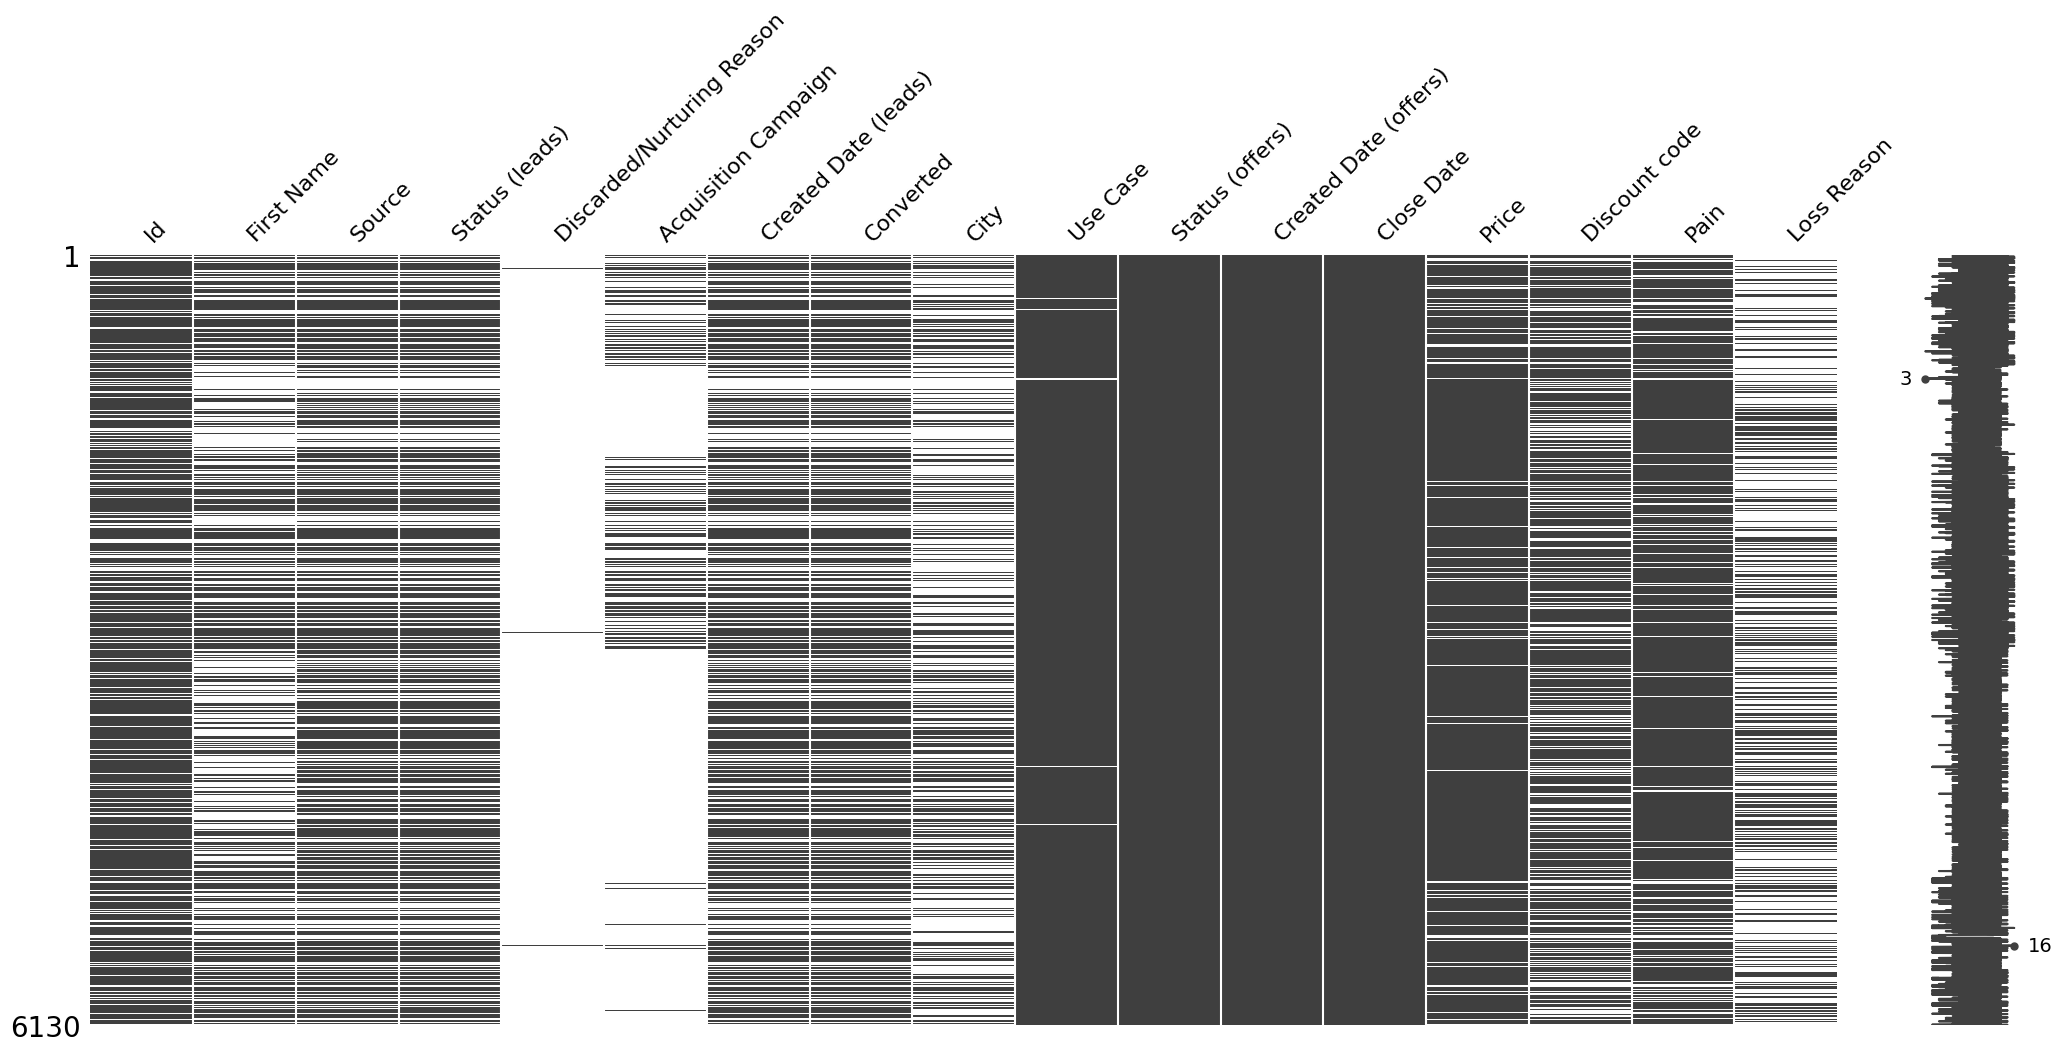

In [14]:
missingno.matrix(df=df_merged)
plt.show()

#### Proporción de registros nulos en la columna 'Discarded/Nurturing Reason'

In [15]:
df_merged['Discarded/Nurturing Reason'].isnull().sum()/len(df_merged)

0.9946166394779772

#### Proporción de filas en las que **Converted** es no núlo y además su valor es 1.0

In [16]:
# print(df_merged['Converted'].value_counts()/len(df_merged)*100)
len(df_merged[df_merged['Converted']==1])/(~df_merged['Converted'].isnull()).sum()

0.9957905814259406

In [17]:
len(df_merged[(df_merged['Status (offers)']=='Closed Won') & (df_merged['Loss Reason'])])

6

En este caso vemos que solo se encuentran 6 registros con la anterior inconsistencia. En este caso no conocemos una manera de determinar si el error se encuentra en la columna 'Loss Reason' o en la columna 'Status'. Por lo que optamos por descartar estos registros. En el caso en que se tuvieran muchos más registros con esta condición descartar estos valores no sería adecuado.

In [18]:
# Borramos filas donde status es "closed won" pero tiene "loss reason"
df_merged.drop(df_merged[(df_merged['Status (offers)']=='Closed Won') & (df_merged['Loss Reason'].notna())].index, inplace=True)
df_merged.head()

,Id,First Name,Source,Status (leads),Discarded/Nurturing Reason,Acquisition Campaign,Created Date (leads),Converted,City,Use Case,Status (offers),Created Date (offers),Close Date,Price,Discount code,Pain,Loss Reason
0,doqyhjtv,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,Educational Seminars,Closed Won,2019-11-17,2019-11-17,300.0,SAVEMORE50,operations,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,Sports Events,Closed Lost,2019-11-24,2019-11-25,150.0,NaN,operations,price
2,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,Sports Events,Closed Lost,2019-11-24,2019-11-25,768.0,HALFYEAR20G,operations,no response
3,cturqi48,Taylor18 Wilson3,Inbound,Qualified,NaN,VirtualMeetups,2019-05-07,1.0,San Diego,Corporate Events,Closed Won,2019-05-07,2019-05-07,240.0,DISCOUNT50POWER,financial control,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,Sports Events,Closed Lost,2019-11-17,2019-11-25,240.0,SAVEMONTH50G,financial control,no response


Podemos ver que tenemos una gran cantidad de valores nulos. Esto no es adecuado para entrenar un modelo de clasificación. Por ahora empecemos descartando algunas columnas que pueden afectar de manera negativa el proceso de entrenamiento de un modelo de clasificación. En primero lugar, eliminamos la variable **Discarded/Nurturing Reason** ya que 99.5% son valores nulos por lo que no es una variable que aporte al modelo de clasificación. Debido a que para cada valor de **Id** es un identificador único del cliente no hace falta tener el nombre así que eliminamos **First Name** y nos quedamos unicamente con su **Id**. La variable converted está relacionada con la conversión de un cliente potencial en un cliente real que a su vez está relacionada con la variable objetivo esto podría generar overfitting en el modelo por esto no es conveniente incluirla en los datos de entrenamiento. Además, la variable **Converted** tiene 62% de valores no nulos de los cuales el 99.5% tienen el mismo valor (1.0) por lo que tampoco sería determinante. La variables **Loss Reason** y **Close Date** nos indica el motivo por el cual un potencial cliente desiste de contratar un servicio y la fecha en la que se registra la respuesta del potencial cliente respectivamente, pero esta información no se conoce antes de que el cliente tome una decisión, es decir no puede ser una variable predictora, también generaría overfitting. Por lo tanto, eliminaremos las siguientes 4 columnas.

In [19]:
df_merged.drop(columns=[
    'Discarded/Nurturing Reason',
    'First Name',
    'Loss Reason',
    'Converted',
    'Close Date'
], axis=1, inplace=True)
df_merged.head()

,Id,Source,Status (leads),Acquisition Campaign,Created Date (leads),City,Use Case,Status (offers),Created Date (offers),Price,Discount code,Pain
0,doqyhjtv,NaN,NaN,NaN,NaT,NaN,Educational Seminars,Closed Won,2019-11-17,300.0,SAVEMORE50,operations
1,NaN,NaN,NaN,NaN,NaT,NaN,Sports Events,Closed Lost,2019-11-24,150.0,NaN,operations
2,NaN,NaN,NaN,NaN,NaT,NaN,Sports Events,Closed Lost,2019-11-24,768.0,HALFYEAR20G,operations
3,cturqi48,Inbound,Qualified,VirtualMeetups,2019-05-07,San Diego,Corporate Events,Closed Won,2019-05-07,240.0,DISCOUNT50POWER,financial control
4,NaN,NaN,NaN,NaN,NaT,NaN,Sports Events,Closed Lost,2019-11-17,240.0,SAVEMONTH50G,financial control


La variable **Price** contiene cerca de un 6% de valores nulos así que puede ser buena idea llenarlos con el valor de algun estadístico teniendo en cuenta el resto de los datos.

Precio
Mediana:  360.0
Media:  1304.7539503386004


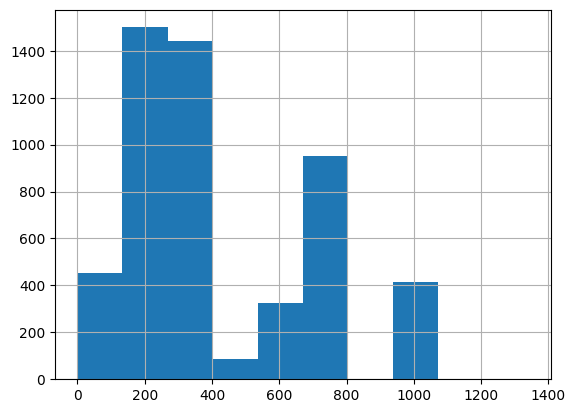

In [20]:
print('Precio')
print('Mediana: ', df_merged['Price'].median())
print('Media: ', df_merged['Price'].mean())
p95 = np.percentile(df_merged['Price'].dropna(), 95)
df_merged[df_merged['Price']<p95]['Price'].hist()
plt.show()

Como vemos que la distribución está sesgada a la derecha optamos por reemplazar estos nulo por la mediana de la distribución del precio.

In [21]:
df_merged['Price'] = df_merged['Price'].fillna(df_merged['Price'].median())

In [22]:
df_merged['Discount code'].value_counts()

Discount code
2SEMESTERS20OFF     553
MONTHSAVE25DEAL     334
MONTH50REBATE       293
HALFYEAR20G         272
SAVE25LESS          264
                   ... 
MATCH75GIFT           1
RENEW60SEASON         1
BARGAIN50MONTHLY      1
BUDGET50SALE          1
ANNUAL60SPECIAL       1
Name: count, Length: 112, dtype: int64

La columna 'Discount code' nos indica un descuento, existen muchos codigos de descuento repetidos, si cada código de descuento estuviera asociado a algún vendedor podríamos considerar cada código como una variable relevante en la predicción pero en este caso no tenemos conocimiento de esto así que por ahora crearemos una variable booleana que nos indique si el registro cuenta con un código de descuento.

In [23]:
df_merged['Has_discount_code'] = ~df_merged['Discount code'].isnull()
df_merged.drop('Discount code', axis=1, inplace=True)
df_merged.head()

,Id,Source,Status (leads),Acquisition Campaign,Created Date (leads),City,Use Case,Status (offers),Created Date (offers),Price,Pain,Has_discount_code
0,doqyhjtv,NaN,NaN,NaN,NaT,NaN,Educational Seminars,Closed Won,2019-11-17,300.0,operations,True
1,NaN,NaN,NaN,NaN,NaT,NaN,Sports Events,Closed Lost,2019-11-24,150.0,operations,False
2,NaN,NaN,NaN,NaN,NaT,NaN,Sports Events,Closed Lost,2019-11-24,768.0,operations,True
3,cturqi48,Inbound,Qualified,VirtualMeetups,2019-05-07,San Diego,Corporate Events,Closed Won,2019-05-07,240.0,financial control,True
4,NaN,NaN,NaN,NaN,NaT,NaN,Sports Events,Closed Lost,2019-11-17,240.0,financial control,True


Tenemos 38% de registros que no cuentan con información que provenga de la tabla leads, por lo que será importante que el modelo tenga esto en cuenta así que creamos una variable booleana que nos indique si dicho cliente se encontró o no en la tabla leads.

In [24]:
df_merged['Is_in_leads'] = offers_df['Id'].isin(leads_df['Id'])

Revisamos nuevamente porcentaje de nulos por columna

In [25]:
df_merged.isnull().sum()/len(df_merged)*100

Id                       19.056172
Source                   37.998040
Status (leads)           37.965382
Acquisition Campaign     82.984977
Created Date (leads)     37.965382
City                     58.866754
Use Case                  0.604180
Status (offers)           0.000000
Created Date (offers)     0.000000
Price                     0.000000
Pain                     14.190072
Has_discount_code         0.000000
Is_in_leads               0.000000
dtype: float64

#### Ahora revisaremos los posibles valores de las variables categóricas que aun contienen nulos

In [26]:
df_merged['Source'].value_counts()/len(df_merged)*100

Source
Inbound             43.125408
Outbound            18.876551
Bot-Intercom         0.000000
Intercom             0.000000
Llamada entrante     0.000000
Mail                 0.000000
Name: count, dtype: float64

In [27]:
df_merged['Status (leads)'].value_counts()/len(df_merged)*100

Status (leads)
Qualified    61.724363
Discarded     0.146963
Nurturing     0.097975
Meeting       0.048988
New           0.016329
Call          0.000000
Called        0.000000
Contacted     0.000000
Email         0.000000
Engaged       0.000000
Linkedin      0.000000
Recicled      0.000000
Name: count, dtype: float64

In [28]:
df_merged['City'].value_counts()/len(df_merged)*100

City
Chicago          10.679295
San Francisco     6.939909
San Diego         2.955585
Jacksonville      2.580013
Washington        1.567603
Indianapolis      1.518615
San Jose          1.420640
San Antonio       1.355323
Seattle           1.338994
New York          1.322665
Columbus          1.306336
Charlotte         1.192031
Denver            1.143044
Austin            0.996081
Phoenix           0.947093
Los Angeles       0.914435
Dallas            0.816460
Houston           0.783801
Philadelphia      0.718485
Fort Worth        0.636839
Name: count, dtype: float64

In [29]:
df_merged['Use Case'].value_counts()/len(df_merged)*100

Use Case
Corporate Events          56.907250
Educational Seminars      21.848465
Sports Events             16.688439
Wedding Planning           3.919007
Concerts and festivals     0.032658
Name: count, dtype: float64

In [30]:
df_merged['Pain'].value_counts()/len(df_merged)*100

Pain
operations             54.065970
financial control      19.529719
quality of delivery    11.038537
time saving             1.175702
Name: count, dtype: float64

In [31]:
df_merged['Created Date (leads)'].value_counts()/len(df_merged)*100

Created Date (leads)
2019-11-09    0.359242
2019-06-23    0.293926
2019-02-06    0.293926
2018-09-23    0.277596
2020-01-27    0.277596
                ...   
2018-05-07    0.016329
2018-09-15    0.016329
2018-08-23    0.016329
2019-05-16    0.016329
2019-03-23    0.016329
Name: count, Length: 569, dtype: float64

Ahora reemplazaremos los nulos del resto de las columnas con el valor 'N/A'

In [32]:
columnas = ['Status (offers)', 'Status (leads)', 'Source', 'Use Case', 'Pain', 'Acquisition Campaign', 'City']
for i in columnas:
    df_merged[i] = df_merged[i].cat.add_categories(['N/A'])
    df_merged[i] = df_merged[i].fillna('N/A')

Verificamos de la columna Id's cuantos id existen duplicados.

In [33]:
(df_merged['Id'].value_counts()>1).value_counts()

count
False    4885
True       35
Name: count, dtype: int64

Debido a que se quiere entrenar un modelo de predicción de convertibilidad de un cliente potencial, los datos con **Id's** estarían sesgados ya fueron potenciales clientes en otro momento. Conservaremos unicamente aquellos con la fecha de creación más antigua.

In [34]:
# Ordenar el DataFrame por 'id' y 'fecha'
df_merged = df_merged.sort_values(by=['Id', 'Created Date (offers)'])

# Eliminar duplicados, manteniendo solo la fila con la fecha más antigua para cada 'id'
df_merged = df_merged.drop_duplicates(subset='Id', keep='first')


La única variable que aun contiene nulos es Created Date (leads)

In [35]:
df_merged[['Created Date (leads)', 'Created Date (offers)']]

,Created Date (leads),Created Date (offers)
2432,2019-04-02,2019-08-21
2954,2019-07-05,2019-07-05
5236,2019-03-13,2019-03-16
2998,2019-03-06,2019-04-06
3383,2019-02-10,2019-02-10
...,...,...
5599,NaT,2019-08-31
4425,2018-07-06,2018-11-06
1784,2019-02-02,2019-11-02
1453,2018-03-03,2018-05-03


Ahora vamos a convertir todas las fechas en días en donde utilizaremos la fecha del registro más antiguo de cada columna como punto de referencia. Además veremos la correlación que hay entre las variables **Created Date (leads)** y **Created Date (offers)** para revisar si es factible imputar valores a partir de una regresión.

                     created_days_leads  created_days_offers
created_days_leads             1.000000             0.877038
created_days_offers            0.877038             1.000000


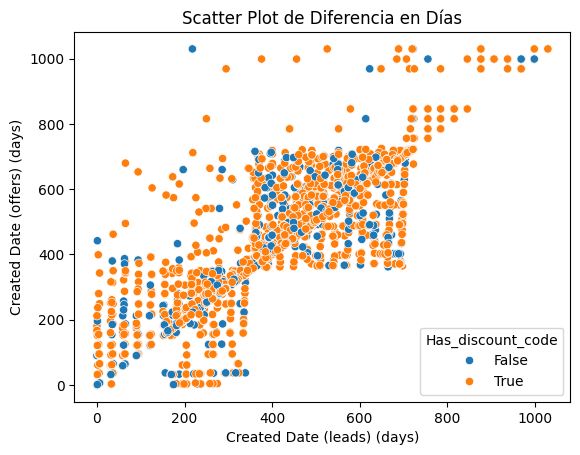

In [36]:
df_merged['created_days_leads'] = (df_merged['Created Date (leads)'] - pd.Timestamp('1970-01-01')).dt.days
df_merged['created_days_offers'] = (df_merged['Created Date (offers)'] - pd.Timestamp('1970-01-01')).dt.days
df_merged['created_days_leads'] = df_merged['created_days_leads'] - df_merged['created_days_leads'].min()
df_merged['created_days_offers'] = df_merged['created_days_offers'] - df_merged['created_days_offers'].min()

df_merged = df_merged.drop(columns=['Created Date (offers)', 'Created Date (leads)'], axis=1)
# Calcular la correlación
correlacion = df_merged[['created_days_leads', 'created_days_offers']].corr()
print(correlacion)

# Crear un scatter plot con Seaborn
sns.scatterplot(x='created_days_leads', y='created_days_offers', hue='Has_discount_code', data=df_merged)

# Personalizar el gráfico
plt.title('Scatter Plot de Diferencia en Días')
plt.xlabel('Created Date (leads) (days)')
plt.ylabel('Created Date (offers) (days)')

# Mostrar el gráfico
plt.show()

Aunque la la correlación es positiva no es adecueado imputar nulos con una regresión ya que no se tiene un relación lineal entre las dos variables, asi que optaremos por reemplazar la variable días por un valor negativo lejano al valor mínimo.

In [37]:
df_merged['created_days_leads'] = df_merged['created_days_leads'].fillna(-1000)

Creamos una función que convierta todas las variables categoricas en variables numéricas utilizando el codigo de cada categoría.

In [38]:
def replace_categorical_with_codes(df):
    """
    Reemplaza todas las columnas de variables categóricas por columnas con los códigos
    correspondientes de las variables categóricas.

    Parameters:
    - df: DataFrame, el DataFrame original con variables categóricas.

    Returns:
    - df_with_codes: DataFrame, el DataFrame modificado con columnas de códigos en lugar de variables categóricas.
    """
    df_with_codes = df.copy()

    for column in df.select_dtypes(include='category').columns:
        # Reemplazar la columna categórica con sus códigos correspondientes
        df_with_codes[column] = df[column].cat.codes

    return df_with_codes

In [39]:
df_predictors = replace_categorical_with_codes(df_merged)

Por último dejaremos únicamente dos fechas, **created_days_leads** y la diferencia de dias entre las dos fechas de creación.

In [40]:
df_predictors['Is_in_leads'] = df_predictors['Is_in_leads'].astype(int)
df_predictors['Has_discount_code'] = df_predictors['Has_discount_code'].astype(int)
df_predictors['days_difference'] = df_predictors['created_days_offers'] - df_predictors['created_days_leads']
df_predictors

,Id,Source,Status (leads),Acquisition Campaign,City,Use Case,Status (offers),Price,Pain,Has_discount_code,Is_in_leads,created_days_leads,created_days_offers,days_difference
2432,004plaq7,1,10,71,20,3,1,0.0,1,0,1,456.0,597,141.0
2954,006hvqrh,1,10,5,20,1,1,240.0,1,1,1,550.0,550,0.0
5236,00dsslbf,1,10,71,20,2,1,768.0,4,1,1,436.0,439,3.0
2998,00ik2lit,1,10,65,20,1,2,360.0,0,1,1,429.0,460,31.0
3383,00m6eiel,1,10,71,20,1,2,240.0,4,1,1,405.0,405,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5599,zzbvnkgd,6,12,71,20,1,2,768.0,1,1,0,-1000.0,607,1607.0
4425,zzc9sbzh,1,10,71,20,1,1,324.0,2,1,1,186.0,309,123.0
1784,zzua9jrh,5,10,71,15,3,2,324.0,1,1,1,397.0,670,273.0
1453,zzuidn21,5,10,71,20,1,1,600.0,1,0,1,61.0,122,61.0


In [41]:
df_merged.to_csv('variables.csv', index=False)
df_predictors.to_csv('variables_numeric.csv', index=False)